### Starting Linear regression on house price prediction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline



Common setup

In [ ]:
np.random.seed(42)

setting shuffle split

In [3]:
cross_validation_shuffle = ShuffleSplit(n_splits=10, test_size= 0.2, random_state= 42)

### Loading and spliting of data

In [4]:
features, labels = fetch_california_housing(return_X_y= True, as_frame= True)
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state= 42)

train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state= 42)

## Linear Regression with normal equation

In [15]:
def printTestResult(result, model:str):
  train_error, test_error = -1 * result['train_score'],  -1 * result['test_score']
  print(f'Mean absolute error of {model} model on the train set:\n',
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

  print(f'Mean absolute error of linear {model} on the test set:\n',
      f'{test_error.mean():.3f} +/- {test_error.std():.3f}')

In [16]:
lin_reg_pipeline = Pipeline([
  ('features_scaling', StandardScaler()),
  ('lin_reg', LinearRegression())
])

lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv= cross_validation_shuffle,
                                    scoring= 'neg_mean_absolute_error',
                                    return_train_score= True,
                                    return_estimator= True)

printTestResult(lin_reg_cv_results, 'Linear Regression')



Mean absolute error of Linear Regression model on the train set:
 0.530 +/- 0.002
Mean absolute error of linear Linear Regression on the test set:
 0.527 +/- 0.008


## Linear regression with SGD


In [17]:
sgd_reg_pipeline = Pipeline([
  ('features_scaling', StandardScaler()),
  ('sgd_reg', SGDRegressor(
    max_iter= int(np.ceil(
      1e6/com_train_features.shape[0])),
      early_stopping= True,
      eta0= 1e-4,
      learning_rate= 'constant',
      tol= 1e-5,
      validation_fraction= 0.1,
      n_iter_no_change= 5,
      average= 10,
      random_state= 42
  ))
])

sgd_reg_cv_result = cross_validate(sgd_reg_pipeline,
                                   com_train_features,
                                   com_train_labels,
                                   cv= cross_validation_shuffle,
                                   scoring= 'neg_mean_absolute_error',
                                   return_train_score= True,
                                   return_estimator= True)
printTestResult(sgd_reg_cv_result, "SGD Regression")

Mean absolute error of SGD Regression model on the train set:
 0.534 +/- 0.013
Mean absolute error of linear SGD Regression on the test set:
 0.530 +/- 0.010


## Polynomial Regression model with Degree 2

In [18]:
poly_reg_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2)),
  ('feature_scaling', StandardScaler()),
  ('lin_reg', LinearRegression())
])

poly_reg_cv_result = cross_validate(poly_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv = cross_validation_shuffle,
                                    scoring= 'neg_mean_absolute_error', 
                                    return_train_score= True,
                                    return_estimator= True)

printTestResult(poly_reg_cv_result, "Polynomial Regression")

Mean absolute error of Polynomial Regression model on the train set:
 0.461 +/- 0.003
Mean absolute error of linear Polynomial Regression on the test set:
 0.485 +/- 0.030


### for only interaction features
interaction features means exclude all higher order features

In [19]:
poly_reg_interact_pipeline = Pipeline([
  ('poly', PolynomialFeatures(degree= 2, interaction_only= True)),
  ('scaler', StandardScaler()),
  ('lin_reg', LinearRegression())
])

poly_interactive_result = cross_validate(poly_reg_interact_pipeline,
                                         com_train_features,
                                         com_train_labels,
                                         cv= cross_validation_shuffle,
                                         scoring='neg_mean_absolute_error',
                                         return_train_score= True,
                                         return_estimator= True)

printTestResult(poly_interactive_result, 'Interactive Polynomial result')

Mean absolute error of Interactive Polynomial result model on the train set:
 0.478 +/- 0.003
Mean absolute error of linear Interactive Polynomial result on the test set:
 0.497 +/- 0.024


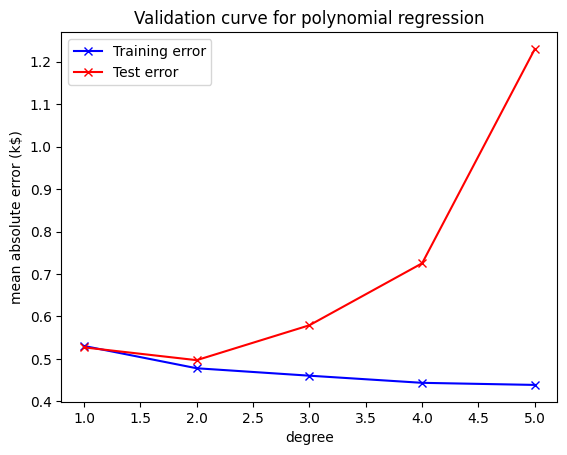

In [21]:
degree = [x for x in range(1, 6)]

train_scores, test_scores =  validation_curve(
  poly_reg_interact_pipeline, com_train_features, com_train_labels, param_name= 'poly__degree',
  param_range= degree, cv = cross_validation_shuffle, scoring='neg_mean_absolute_error', n_jobs=2
)

train_errors, test_errors = -train_scores, -test_scores

plt.plot(degree, train_errors.mean(axis= 1), 'b-x', label='Training error')
plt.plot(degree, test_errors.mean(axis= 1), 'r-x', label='Test error')
plt.legend()

plt.xlabel('degree')
plt.ylabel('mean absolute error (k$)')
plots = plt.title('Validation curve for polynomial regression')
